# Проект: классификация клиентов банка


## Задача: Привлечение клиентов для открытия депозита

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Знакомство с данными, обработка пропусков и выбросов

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [5]:
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [6]:
df['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [7]:
df['balance'] = df['balance'].replace(regex=r'\s' ,value='') 
df['balance'] = df['balance'].replace(regex=r'[$]',value='')
df['balance'] = df['balance'].replace(regex=r',00',value='') 
df['balance'] = df['balance'].astype(float)
df['balance'].mean().__round__(3)

1529.129

In [8]:
df['balance'] = df['balance'].fillna(df['balance'].median())
df['balance'].mean().__round__(3)

1526.936

In [9]:
df['job'] = df['job'].apply(lambda x: df['job'].mode().loc[0] if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode().loc[0] if x == 'unknown' else x)
df[(df['job'] == 'management') & (df['education'] == 'secondary')]['balance'].mean().__round__(3)


1598.883

In [10]:
x = df['balance']
quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
outliers = df[(x<lower_bound) | (x > upper_bound)]
cleaned = df[(x>=lower_bound) & (x <= upper_bound)]
print(f'Нижняя граница по методу Тьюки: {lower_bound}')
print(f'Верхняя граница по методу Тьюки: {upper_bound}')

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

df_out_clr = df.drop(outliers.index)

Нижняя граница по методу Тьюки: -2241.0
Верхняя граница по методу Тьюки: 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


## Разведывательный анализ

deposit
no     5424
yes    4681
dtype: int64


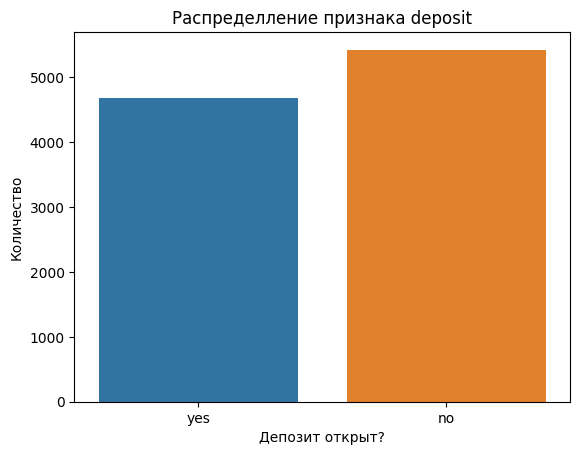

In [11]:
# изучу соотношение классов в данных на предмет несбалансированности
print(df_out_clr.value_counts('deposit'))

dep_fig = sns.countplot(df_out_clr['deposit'])
dep_fig.set_title(label='Распределление признака deposit')
dep_fig.set_xlabel('Депозит открыт?')
dep_fig.set_ylabel('Количество');


# данные достаточно хорошо сбалансированы , сильных отклонений нет

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


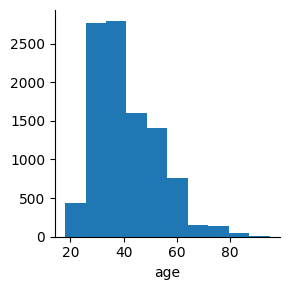

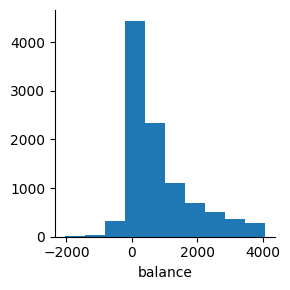

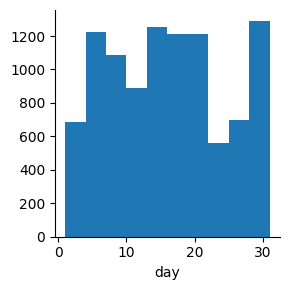

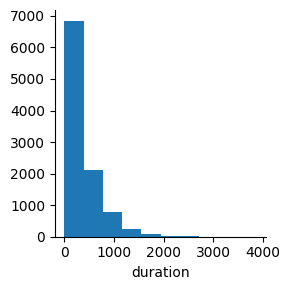

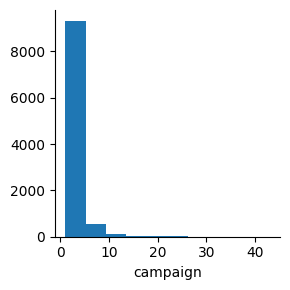

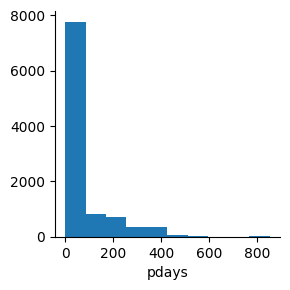

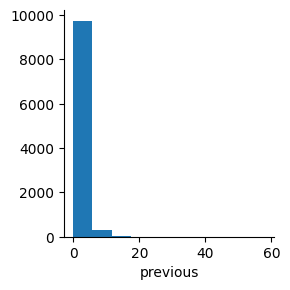

In [12]:
#рассчитаю описательные статистики для количественных переменных
cnt = df_out_clr.describe()
display(cnt)
countable = cnt.columns

for col in countable:
    plot = sns.FacetGrid(df_out_clr)
    plot.map(plt.hist, col)

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


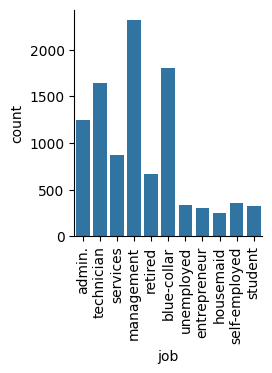

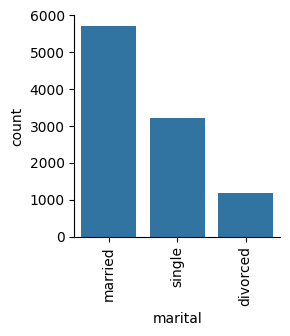

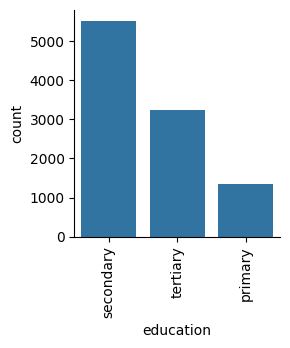

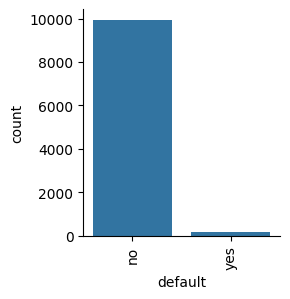

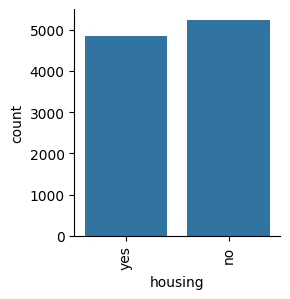

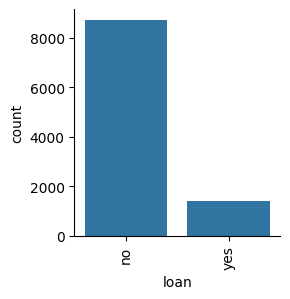

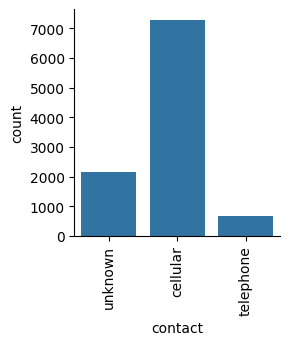

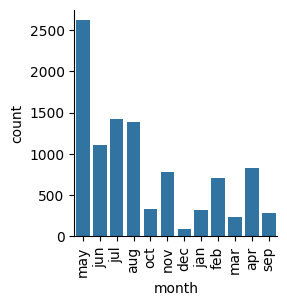

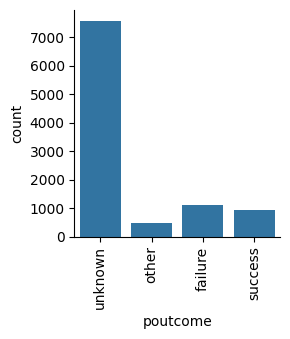

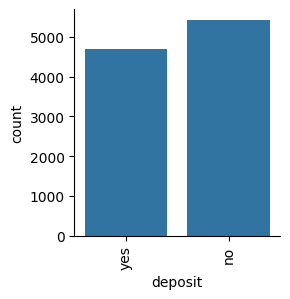

In [13]:
# описательные статистики для категориальных переменных
obj = df_out_clr.describe(include='object')
display(obj)
objt = obj.columns

for cols in objt:
    plot = sns.FacetGrid(df_out_clr)
    plot.map(sns.countplot, cols)
    plot.set_xticklabels(rotation=90)
    
# Из расчитанных данных можно вывести несколько ключевых моментов , маркетинговая компания развернулась в основном на месяц май , и основной аудиторией были клиенты состоящие в браке , 
# без задолженностей по кредитам или их отсутствии.

In [14]:
# для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
pout_grouped = df_out_clr.groupby('poutcome')['deposit']
pout_grouped.value_counts()

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

In [15]:
# в каком месяце чаще всего отказывались от предложения открыть депозит
month_groped = df_out_clr.groupby('month')['deposit']
display(month_groped.value_counts(normalize=True)*100)

month  deposit
apr    yes        61.807229
       no         38.192771
aug    no         55.956679
       yes        44.043321
dec    yes        90.322581
       no          9.677419
feb    yes        54.442877
       no         45.557123
jan    no         60.815047
       yes        39.184953
jul    no         58.956276
       yes        41.043724
jun    no         54.891304
       yes        45.108696
mar    yes        89.873418
       no         10.126582
may    no         67.863966
       yes        32.136034
nov    no         58.461538
       yes        41.538462
oct    yes        81.492537
       no         18.507463
sep    yes        83.453237
       no         16.546763
Name: deposit, dtype: float64

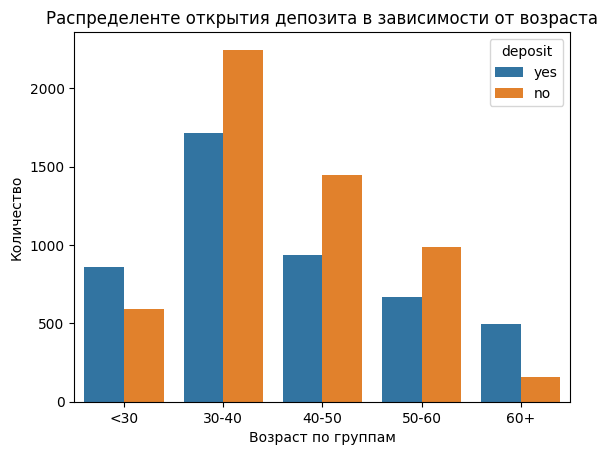

In [16]:
# создам возрастные группы и определю, в каких группах более склонны открывать депозит, чем отказываться от предложения
df_out_clr['age'] = pd.cut(x=df_out_clr['age'], bins=[0,30,40,50,60,100], labels=['<30','30-40','40-50','50-60','60+'], right=False)

cntplt_age = sns.countplot(data=df_out_clr, x='age', hue='deposit') 
cntplt_age.set_title('Распределенте открытия депозита в зависимости от возраста')
cntplt_age.set_xlabel('Возраст по группам')
cntplt_age.set_ylabel('Количество');

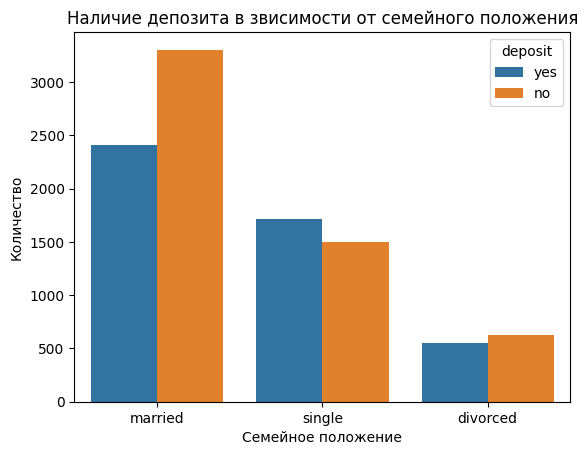

In [17]:
# визуализация для открывших и неоткрывших депозит в зависимости от семейного 
mar_status = sns.countplot(data = df_out_clr, x='marital', hue='deposit')
mar_status.set_title('Наличие депозита в звисимости от семейного положения')
mar_status.set_ylabel('Количество')
mar_status.set_xlabel('Семейное положение');

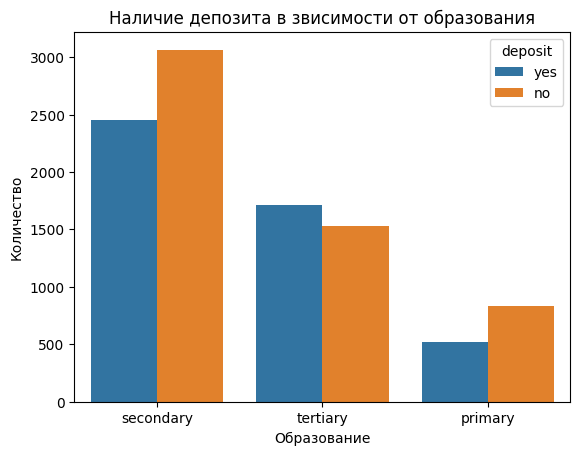

In [18]:
# визуализация для открывших и неоткрывших депозит в зависимости от образования
education = sns.countplot(data = df_out_clr, x='education', hue='deposit')
education.set_title('Наличие депозита в звисимости от образования')
education.set_ylabel('Количество')
education.set_xlabel('Образование');

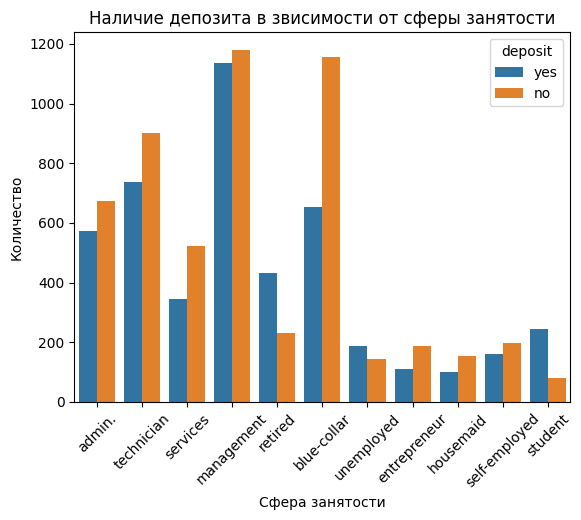

In [19]:
# визуализация для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
job = sns.countplot(data = df_out_clr, x='job', hue='deposit')
job.set_title('Наличие депозита в звисимости от сферы занятости')
job.set_ylabel('Количество')
job.set_xlabel('Сфера занятости')
job.set_xticklabels(job.get_xticklabels(), rotation=45);

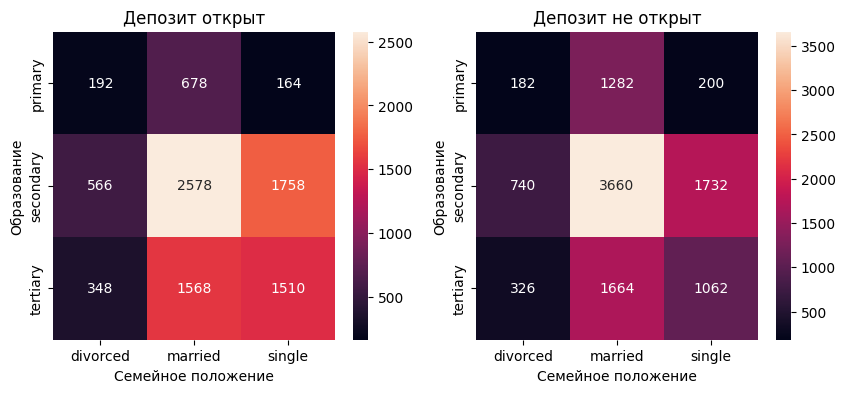

In [20]:
# сводная таблица, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
dep_yes = df_out_clr[df_out_clr['deposit'] == 'yes'][['education','marital']]
dep_no = df_out_clr[df_out_clr['deposit'] == 'no'][['education','marital']]
# cntplt_yes = sns.countplot(data=dep_yes, x='education', hue='marital')

pivot_yes = pd.pivot_table(dep_yes, columns='marital', index='education', aggfunc=np.count_nonzero, )
pivot_no = pd.pivot_table(dep_no, columns='marital', index='education', aggfunc=np.count_nonzero, )


plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
heat_yes = sns.heatmap(data=pivot_yes, annot=True, fmt='d')
heat_yes.set_title('Депозит открыт')
heat_yes.set_xlabel('Семейное положение')
heat_yes.set_ylabel('Образование')
plt.subplot(1,2,2)
heat_no = sns.heatmap(data=pivot_no, annot=True, fmt='d')
heat_no.set_title('Депозит не открыт')
heat_no.set_xlabel('Семейное положение')
heat_no.set_ylabel('Образование');

## преобразование данных

In [21]:
# преобразую уровни образования
LE = preprocessing.LabelEncoder()
df_out_clr['education'] = LE.fit_transform(df_out_clr['education'])
df_out_clr['education'].sum()

df_out_clr['gr_age'] = LE.fit_transform(df_out_clr['age'])

df_out_clr = df_out_clr.drop('age', axis=1)



In [22]:
# преобразую бинарные переменные в представление из нулей и единиц
df_out_clr['deposit'] = df_out_clr['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
display(df_out_clr['deposit'].std().__round__(3))

df_out_clr['loan'] = df_out_clr['loan'].apply(lambda x: 1 if x == 'yes' else 0)
df_out_clr['housing'] = df_out_clr['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df_out_clr['default'] = df_out_clr['default'].apply(lambda x: 1 if x == 'yes' else 0)

print(round(df_out_clr['loan'].mean() +  df_out_clr['housing'].mean() + df_out_clr['default'].mean(),3))

0.499

0.635


In [23]:
df_dum = pd.get_dummies(df_out_clr)
df_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   education          10105 non-null  int32  
 1   default            10105 non-null  int64  
 2   balance            10105 non-null  float64
 3   housing            10105 non-null  int64  
 4   loan               10105 non-null  int64  
 5   day                10105 non-null  int64  
 6   duration           10105 non-null  int64  
 7   campaign           10105 non-null  int64  
 8   pdays              10105 non-null  int64  
 9   previous           10105 non-null  int64  
 10  deposit            10105 non-null  int64  
 11  gr_age             10105 non-null  int32  
 12  job_admin.         10105 non-null  uint8  
 13  job_blue-collar    10105 non-null  uint8  
 14  job_entrepreneur   10105 non-null  uint8  
 15  job_housemaid      10105 non-null  uint8  
 16  job_management     101

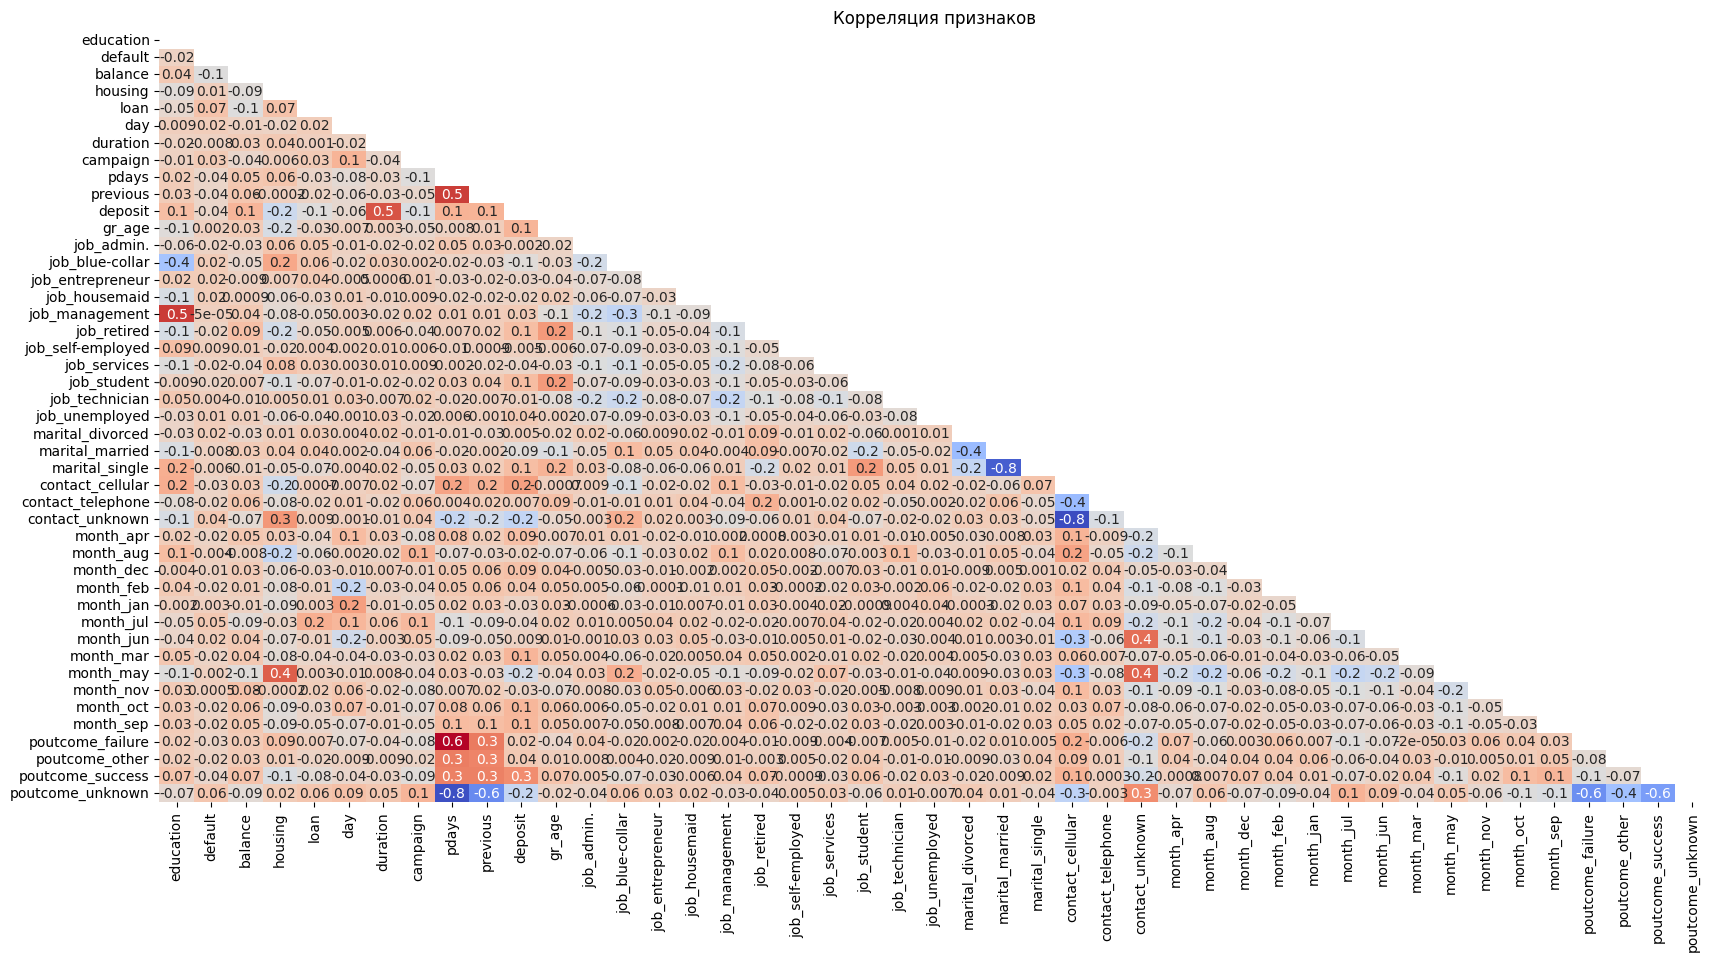

In [24]:
# построю корреляционную матрицу и оценю данные на предмет наличия мультиколлинеарности

# display(df_dum.corr())
plt.figure(figsize=[20,10])
corr_heat = sns.heatmap(df_dum.corr(), annot = True, fmt='.1g', cmap= 'coolwarm',cbar=False, mask = np.triu(df_dum.corr()))
corr_heat.set_title('Корреляция признаков');

In [25]:
X = df_dum.drop(['deposit'], axis=1)
y = df_dum['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [27]:
# с помощью SelectKBest отберу 15 наиболее подходящих признаков
selectkb = SelectKBest(score_func = f_classif, k=15)
selectkb.fit(X_train, y_train)

selectkb.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'gr_age', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [28]:
x = df_dum[['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'gr_age', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown']]
y = df_dum['deposit']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state = 42, test_size = 0.33)

In [30]:
# нормализую данные с помощью minmaxscaler
MMscaler = preprocessing.MinMaxScaler()
MMscaler.fit(X_train)
X_train_scaled = pd.DataFrame(MMscaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(MMscaler.transform(X_test), columns=X_test.columns)

In [31]:
round(X_test_scaled['balance'].mean(),2)

0.47

# логистическая регрессия и решающие деревья

In [32]:
# обучу логистическую регрессию и рассчитаю метрики качества
log_reg = linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_test_pred = log_reg.predict(X_test_scaled)
print('Accuracy score для тестовой выборки: {}'.format(round(metrics.accuracy_score(y_test, y_test_pred),3)))

Accuracy score для тестовой выборки: 0.805


In [33]:
# обучу решающие деревья, настрою максимальную глубину
d_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
d_tree.fit(X_train_scaled, y_train)
y_test_pred_dt = d_tree.predict(X_test_scaled)
print(round(metrics.accuracy_score(y_test, y_test_pred_dt),2))
y_train_pred_dt = d_tree.predict(X_train_scaled)
print(round(metrics.accuracy_score(y_train, y_train_pred_dt),2))

0.75
1.0


In [34]:
for i in range(1,10,1):
    d_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=i)
    d_tree.fit(X_train_scaled, y_train)
    y_test_pred_dt = d_tree.predict(X_test_scaled)
    print(f'Глубина дерева = {i}')
    print(round(metrics.accuracy_score(y_test, y_test_pred_dt),2))
    y_train_pred_dt = d_tree.predict(X_train_scaled)
    print(round(metrics.accuracy_score(y_train, y_train_pred_dt),2))

Глубина дерева = 1
0.71
0.71
Глубина дерева = 2
0.72
0.73
Глубина дерева = 3
0.77
0.78
Глубина дерева = 4
0.77
0.78
Глубина дерева = 5
0.79
0.8
Глубина дерева = 6
0.81
0.82
Глубина дерева = 7
0.82
0.84
Глубина дерева = 8
0.81
0.84
Глубина дерева = 9
0.81
0.85


In [35]:
# подберу оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {  'min_samples_split': [2, 5, 7, 10],
                'max_depth':[3,5,7], 
              }
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
         random_state=42
    ), 
    param_grid=param_grid,  
    n_jobs = -1
)  

grid_search.fit(X_train_scaled, y_train) 

y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# ансамбли моделей и построение прогноза

In [36]:
# обучу на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=5, max_depth=10, random_state=42)
rf.fit(X_train_scaled, y_train)

y_test_pred_rf = rf.predict(X_test_scaled)
print('Accuracy score для тестовой выборки: {}'.format(round(metrics.accuracy_score(y_test, y_test_pred_rf),3)))
print('Recall для тестовой выборки: {}'.format(round(metrics.recall_score(y_test, y_test_pred_rf),3)))

print('F1 score для тестовой выборки: {}'.format(round(metrics.f1_score(y_test, y_test_pred_rf),3)))

Accuracy score для тестовой выборки: 0.828
Recall для тестовой выборки: 0.835
F1 score для тестовой выборки: 0.819


In [37]:
gr_boost = ensemble.GradientBoostingClassifier( learning_rate = 0.05,
                                                n_estimators = 300,
                                                min_samples_leaf = 5,
                                                max_depth = 5,
                                                random_state = 42)

gr_boost.fit(X_train_scaled, y_train)

y_test_pred_gr = gr_boost.predict(X_test_scaled)
print('F1 score для тестовой выборки: {}'.format(round(metrics.f1_score(y_test, y_test_pred_gr),3)))

F1 score для тестовой выборки: 0.817


In [38]:
# объеденю алгоритмы с помощью стекинга 
stack = ensemble.StackingClassifier(estimators=[('dt',d_tree),('gb', gr_boost)],
                                    final_estimator=log_reg,
                                    n_jobs=-1)
stack.fit(X_train_scaled, y_train)

y_test_pred_stack = stack.predict(X_test_scaled)
print('Precision score для тестовой выборки: {}'.format(round(metrics.precision_score(y_test, y_test_pred_stack),3)))

Precision score для тестовой выборки: 0.805


In [39]:
# признаки которые показывают наибольшую  важность в модели градиентного бустинга
selectkb_3 = SelectKBest(score_func = f_classif, k=3)
selectkb_3.fit(X_train_scaled, y_train)

selectkb_3.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

In [40]:
# оптимизирую гиперпараметры с помощью Optuna
import optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [41]:
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

study.optimize(optuna_rf, n_trials=20)

[I 2022-09-30 21:58:13,706] A new study created in memory with name: RandomForestClassifier
[I 2022-09-30 21:58:14,511] Trial 0 finished with value: 0.8505639097744362 and parameters: {'n_estimators': 172, 'max_depth': 16, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8505639097744362.
[I 2022-09-30 21:58:15,266] Trial 1 finished with value: 0.8569638101206328 and parameters: {'n_estimators': 162, 'max_depth': 13, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8569638101206328.
[I 2022-09-30 21:58:16,206] Trial 2 finished with value: 0.8458398744113029 and parameters: {'n_estimators': 176, 'max_depth': 17, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8569638101206328.
[I 2022-09-30 21:58:17,135] Trial 3 finished with value: 0.8942428035043805 and parameters: {'n_estimators': 149, 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8942428035043805.
[I 2022-09-30 21:58:17,996] Trial 4 finished with value: 0.8616155291170945 and parameters: {'n

In [42]:
study.optimize(optuna_rf, n_trials=20)

[I 2022-09-30 21:58:31,395] Trial 20 finished with value: 0.8689396309039724 and parameters: {'n_estimators': 119, 'max_depth': 22, 'min_samples_leaf': 5}. Best is trial 7 with value: 0.9253684540608341.
[I 2022-09-30 21:58:32,666] Trial 21 finished with value: 0.9254619480112747 and parameters: {'n_estimators': 188, 'max_depth': 25, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.9254619480112747.
[I 2022-09-30 21:58:33,842] Trial 22 finished with value: 0.925705329153605 and parameters: {'n_estimators': 186, 'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.925705329153605.
[I 2022-09-30 21:58:34,936] Trial 23 finished with value: 0.8950742767787334 and parameters: {'n_estimators': 189, 'max_depth': 29, 'min_samples_leaf': 3}. Best is trial 22 with value: 0.925705329153605.
[I 2022-09-30 21:58:36,015] Trial 24 finished with value: 0.9252936570086139 and parameters: {'n_estimators': 170, 'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 22 with value:

In [43]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

Наилучшие значения гиперпараметров {'n_estimators': 186, 'max_depth': 26, 'min_samples_leaf': 2}


In [44]:
rf_optuna = ensemble.RandomForestClassifier(n_estimators=112,
                                          max_depth=28,
                                          min_samples_leaf=2,
                                          random_state=42)
rf_optuna.fit(X_train_scaled, y_train)

y_test_pred_optuna = rf_optuna.predict(X_test_scaled)
print('Accuracy score для тестовой выборки: {}'.format(round(metrics.accuracy_score(y_test, y_test_pred_optuna),3)))
print('F1 score для тестовой выборки: {}'.format(round(metrics.f1_score(y_test, y_test_pred_optuna),3)))

Accuracy score для тестовой выборки: 0.826
F1 score для тестовой выборки: 0.818


In [48]:
y_true = [1.23, 2.35, 2.75]
y_pred = [1.01, 12.3, 2.74]
np.sqrt(metrics.mean_squared_error(y_true, y_pred))


5.746042116100439